#  The Deterministic Cake Eating Problem - Policy Function Iteration Solution
### by [Jason DeBacker](http://jasondebacker.com), June 2018
This Jupyter notebook illustrates how to solve the deterministic cake eating problem using Coleman's policy function iteration (PFI).

## The Problem:

$$V(w)=\max_{c} u(c)+\beta V(w'), \forall w\in[0,\bar{w}]$$

The necessary condition (after applying the envelope theorem) is given by the Euler equation:

$$ u'(c) = \beta u'(c') $$

The unknowns in this system are functions: The value function, $V(w)$, and the policy function, $c = \phi(w)$ (or, equivalently, $w' = p(w)$).

## The Solution:

We'll solve this problem with policy function iteration (PFI).  With this method, we'll use an iterative procedure to converge to a fixed point in function space, the true policy function, $\phi(w)$.  

The computational algorithm for PFI is as follows:

1. Create a discrete grid of the state variable, $w$
2. Make an initial guess at the policy function, $\phi_{0}(w)$
    * This will be a consumption value for each point in the state space
3. Find $K\phi(w)$, where $K\phi(w)$ is the root  of:
$$ u'(K\phi(w)) - \beta u'(\phi_{0}(w - K\phi(w)) = 0$$
4. Update the guess at the policy function: $\phi_{1}(w) = K\phi(w)$
5. Repeat this process:
$$\phi_{i+1} \ (w) = K\phi(w), \text{ where } K\phi(w) \text{ solves } u'(K\phi(w)) - \beta u'(\phi_{i}(w - K\phi(w)) = 0$$
6. Stop when, $|\phi_{i+1} \ (w)-\phi_{i}(w)|<\varepsilon$, where $\varepsilon$ is a small number.



In [1]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
from scipy.optimize import fminbound
from scipy import interpolate

# to print plots inline
%matplotlib inline

## Step 1: Set parameters and create grid for state space

Parameters:
* $\beta$ = rate of time preference
* $\sigma$ = coefficient of relative risk aversion (if $\sigma = 1$, $u(c)=log(c)$), parameter describes the curvature of the utility function

In [2]:
beta = 0.95
sigma = 1.0
R = 1

'''
------------------------------------------------------------------------
Create Grid for State Space    
------------------------------------------------------------------------
lb_w      = scalar, lower bound of cake grid
ub_w      = scalar, upper bound of cake grid 
size_w    = integer, number of grid points in cake state space
w_grid    = vector, size_w x 1 vector of cake grid points 
------------------------------------------------------------------------
'''
lb_w = 0.4 
ub_w = 2.0 
size_w = 200  # Number of grid points
w_grid = np.linspace(lb_w, ub_w, size_w)

## Step 2: Create functions to use in solution

In [3]:
def utility(w, wprime, sigma, R):
    """
    Per period utility function
    """
    C = w - wprime / R
    try:
        C[C<=0] = 1e-10 # replace 0 and negative consumption with a tiny value - to impose non-negativity on cons
    except TypeError:
        if C <= 0:
            C = 1e-10
    if sigma == 1:
        U = np.log(C)
    else:
        U = (C ** (1 - sigma)) / (1 - sigma)
    
    return U


def u_prime(C, sigma):
    MU = C ** - sigma
    try:
        MU[C<=0] = 999999999 # replace 0 and negative consumption with a tiny value - to impose non-negativity on cons
    except TypeError:
        if C <= 0:
            MU = 999999999
    
    return MU

In [4]:
def coleman_operator(phi, w_grid, params):
    '''
    The Coleman operator, which takes an existing guess phi of the
    optimal consumption policy and computes and returns the updated function
    Kphi on the grid points.
    '''
    beta, sigma = params
    
    # === Apply linear interpolation to phi === #
    phi_func = interpolate.interp1d(w_grid, phi, fill_value='extrapolate')

    # == Initialize Kphi if necessary == #
    Kphi = np.empty_like(phi)

    # == solve for updated consumption value
    for i, w in enumerate(w_grid):
        def h(c):
            return u_prime(c, sigma) - beta * u_prime(phi_func(R * (w - c)), sigma)
        results = opt.root(h, 1e-10)
        c_star = results.x[0]
        Kphi[i] = c_star
        
    return Kphi

## Step 3: Policy Function Iteration

In [5]:
'''
------------------------------------------------------------------------
Policy Function Iteration    
------------------------------------------------------------------------
PFtol     = scalar, tolerance required for policy function to converge
PFdist    = scalar, distance between last two policy functions
PFmaxiter = integer, maximum number of iterations for policy function
phi       = vector, policy function for choice of consumption at each iteration
PFstore   = matrix, stores phi at each iteration 
PFiter    = integer, current iteration number
PF_params = tuple, contains parameters to pass into Coleman operator: beta, sigma
new_phi   = vector, updated policy function after applying Coleman operator 
------------------------------------------------------------------------
'''
PFtol = 1e-8 
PFdist = 7.0 
PFmaxiter = 500 
phi = w_grid # initial guess at policy function is to eat all cake
PFstore = np.zeros((size_w, PFmaxiter)) #initialize PFstore array
PFiter = 1 
PF_params = (beta, sigma)
while PFdist > PFtol and PFiter < PFmaxiter:
    PFstore[:, PFiter] = phi
    new_phi = coleman_operator(phi, w_grid, PF_params)
    PFdist = (np.absolute(phi - new_phi)).max()
    phi = new_phi
    print('Iteration ', PFiter, ' distance = ', PFdist)
    PFiter += 1

if PFiter < PFmaxiter:
    print('Policy function converged after this many iterations:', PFiter)
else:
    print('Policy function did not converge')            

Iteration  1  distance =  0.9743589743589745
Iteration  2  distance =  0.3245016741949327
Iteration  3  distance =  0.16203762968996904
Iteration  4  distance =  0.09705232549890097
Iteration  5  distance =  0.06456000857510014
Iteration  6  distance =  0.04599332036889442
Iteration  7  distance =  0.034389500854108024
Iteration  8  distance =  0.02665398942464242
Iteration  9  distance =  0.021239505165381423
Iteration  10  distance =  0.017302076043669207
Iteration  11  distance =  0.014349384407750049
Iteration  12  distance =  0.012078464911242037
Iteration  13  distance =  0.010294553477425028
Iteration  14  distance =  0.00886780674902729
Iteration  15  distance =  0.007708956780644871
Iteration  16  distance =  0.006754990271822581
Iteration  17  distance =  0.005960396989169808
Iteration  18  distance =  0.005291642456029366
Iteration  19  distance =  0.00472357520273306
Iteration  20  distance =  0.004237031601989405
Iteration  21  distance =  0.003817202803910874
Iteration  2

Iteration  167  distance =  9.527378355550509e-07
Iteration  168  distance =  9.050841318636316e-07
Iteration  169  distance =  8.598147528404709e-07
Iteration  170  distance =  8.168103225042467e-07
Iteration  171  distance =  7.759574489757393e-07
Iteration  172  distance =  7.371484242874038e-07
Iteration  173  distance =  7.002809383066522e-07
Iteration  174  distance =  6.652578082161353e-07
Iteration  175  distance =  6.319867203591345e-07
Iteration  176  distance =  6.003799863374404e-07
Iteration  177  distance =  5.703543103363629e-07
Iteration  178  distance =  5.418305693283276e-07
Iteration  179  distance =  5.147336029631688e-07
Iteration  180  distance =  4.889920150602522e-07
Iteration  181  distance =  4.645379851897502e-07
Iteration  182  distance =  4.4130708874712266e-07
Iteration  183  distance =  4.192381267975609e-07
Iteration  184  distance =  3.982729648160932e-07
Iteration  185  distance =  3.7835637835270663e-07
Iteration  186  distance =  3.594359077180309e-0

## Step 4: Extract decision rules from solution

In [6]:
'''
------------------------------------------------------------------------
Find savings policy function and value function   
------------------------------------------------------------------------
optC  = vector, the optimal choice of c for each c
optW  = vector, the optimal choice of w' for each w
VF    = vector, the "true" value function
------------------------------------------------------------------------
'''
optC = phi # optimal consumption
optW = R * (w_grid - optC) # solution to the savings policy function from transition equation

## Visualize output

<Figure size 432x288 with 0 Axes>

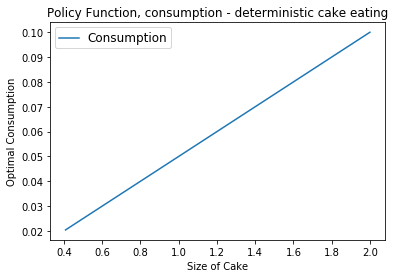

In [7]:
#Plot optimal consumption rule as a function of cake size
plt.figure()
fig, ax = plt.subplots()
ax.plot(w_grid[1:], optC[1:], label='Consumption')
# Now add the legend with some customizations.
legend = ax.legend(loc='upper left', shadow=False)
# Set the fontsize
for label in legend.get_texts():
    label.set_fontsize('large')
for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width
plt.xlabel('Size of Cake')
plt.ylabel('Optimal Consumption')
plt.title('Policy Function, consumption - deterministic cake eating')
plt.show()

<Figure size 432x288 with 0 Axes>

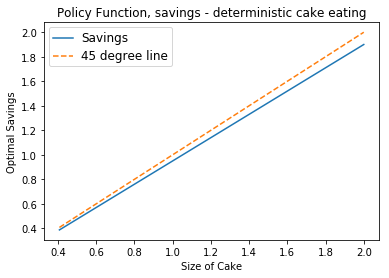

In [8]:
#Plot cake to leave rule as a function of cake size
plt.figure()
fig, ax = plt.subplots()
ax.plot(w_grid[1:], optW[1:], label='Savings')
ax.plot(w_grid[1:], w_grid[1:], '--', label='45 degree line')
# Now add the legend with some customizations.
legend = ax.legend(loc='upper left', shadow=False)
# Set the fontsize
for label in legend.get_texts():
    label.set_fontsize('large')
for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width
plt.xlabel('Size of Cake')
plt.ylabel('Optimal Savings')
plt.title('Policy Function, savings - deterministic cake eating')
plt.show()

## Finding approximation errors

It's a little complicated (we need to do the guess and verify method), but we can show that with $\sigma = 1.0$ (i.e., $u(c) = log(c)$), then the policy function is $w' = \beta w$.  Knowing this, we can find the approximation error from our solution method (VFI over a discrete grid).  This errors are found as:

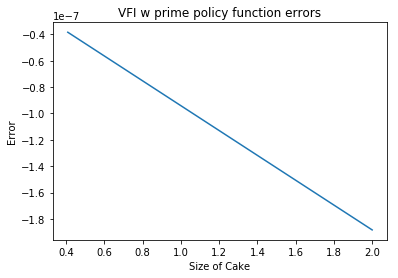

In [9]:
Wprime_errors = optW - beta * w_grid

# Plot policy function approximation errors
plt.figure()
plt.plot(w_grid[1:], Wprime_errors[1:])
plt.xlabel('Size of Cake')
plt.ylabel('Error')
plt.title('VFI w prime policy function errors')
plt.show()

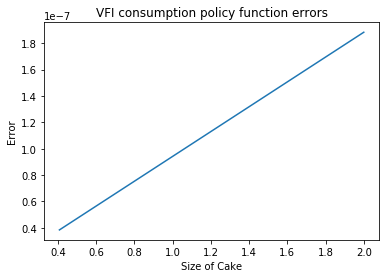

In [10]:
C_errors = optC - (1 - beta) * w_grid
# Plot policy function approximation errors
plt.figure()
plt.plot(w_grid[1:], C_errors[1:])
plt.xlabel('Size of Cake')
plt.ylabel('Error')
plt.title('VFI consumption policy function errors')
plt.show()